In [2]:
models = sorted(list(Path('assets/').rglob('*/model.pt')))

In [8]:
path

PosixPath('assets/exp16/model.pt')

In [27]:
parm = torch.load(path, map_location=torch.device('cpu'))['model_state_dict']

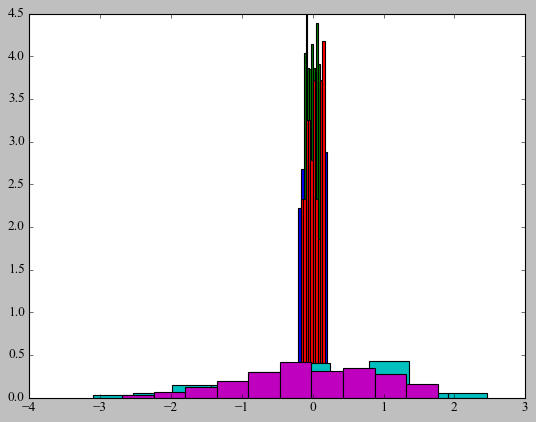

In [47]:
for i in func.parameters():
    if len(i.shape) == 2:
        plt.hist(i.flatten().data.numpy(), density=True)

In [3]:
data = DataLoader(DataNPZ('val'), batch_size=4314)
v, z = next(iter(data))
z0, z1 = z[:, 0], z[:, 1]
t = torch.linspace(0, 5, 80)

df_metrics = {
    'exp': [],
    'loss': [],
    'metric': [],
    'val': [],
    'value': []
}

for path in models:

    num = int(str(path.parent).replace('assets/exp', ''))
    name = str(path.parent).replace('assets/', '')

    loss = config[name]['lf']
    layers = [int(i) for i in config[name]['l'].split(' ')]
    embs = [int(i) for i in config[name]['emb'].split(' ')]

    if num <= 5: 
        func = LinearODEF(layers, embs, nn.Tanh)
    elif 5 < num <= 10:
        func = EmbededLinearODEF(layers, embs, nn.Tanh)
    elif 10 < num <= 15:
        func = MultyLayerODEF(layers, embs, nn.Tanh)
    elif 15 < num <= 20:
        func = MultyLayerODEF(layers, embs, nn.ReLU)
        
    func.load_state_dict(torch.load(path, map_location=torch.device('cpu'))['model_state_dict'])
    func.eval()

    pred = odeint(func, z0, v, t, method='rk4')[-1]

    for metric in CRITERION.keys():

        df_metrics['exp'].append(num)
        df_metrics['loss'].append(loss)
        df_metrics['metric'].append(metric)
        df_metrics['val'].append(1)
        df_metrics['value'].append(CRITERION[metric](z1[:, 0], pred[:, 0]).item())

        df_metrics['exp'].append(num)
        df_metrics['loss'].append(loss)
        df_metrics['metric'].append(metric)
        df_metrics['val'].append(2)
        df_metrics['value'].append(CRITERION[metric](z1[:, 1], pred[:, 1]).item())

        df_metrics['exp'].append(num)
        df_metrics['loss'].append(loss)
        df_metrics['metric'].append(metric)
        df_metrics['val'].append(3)
        df_metrics['value'].append(CRITERION[metric](z1, pred).item())

df_metrics = pd.DataFrame().from_dict(df_metrics)
df_metrics.to_csv('assets/final_metrics.csv', index=False)


RuntimeError: Error(s) in loading state_dict for MultyLayerODEF:
	Missing key(s) in state_dict: "net.0.running_mean", "net.0.running_var", "net.1.layer.0.weight", "net.1.layer.0.bias", "net.2.layer.0.weight", "net.2.layer.0.bias", "net.3.layer.0.weight", "net.3.layer.0.bias", "embeddings.soil_emb.weight", "embeddings.cover_emb.weight". 
	Unexpected key(s) in state_dict: "soil_emb.weight", "cover_emb.weight", "norm.running_mean", "norm.running_var", "norm.num_batches_tracked", "reg.weight", "reg.bias". 

In [ ]:
df = df_metrics[(df_metrics.exp >= 6) & (df_metrics.metric == 'MAE')][['loss', 'val', 'value']]
idx = ['MAE', 'MSE', 'SmoothMAE', 'WAPE', 'SMAPE']
#print(df.pivot_table(index=['loss'], values=['value'], columns='val').loc[idx].round(3).to_latex())
df.pivot_table(index=['loss'], values=['value'], columns='val').loc[idx].round(3)

\begin{tabular}{lrrr}
\toprule
{} & \multicolumn{3}{l}{value} \\
val &      1 &      2 &      3 \\
loss      &        &        &        \\
\midrule
MAE       &  4.264 &  7.464 &  5.864 \\
MSE       &  4.260 &  7.387 &  5.823 \\
SmoothMAE &  4.263 &  7.464 &  5.863 \\
WAPE      &  4.264 &  7.464 &  5.864 \\
SMAPE     &  4.266 &  7.483 &  5.874 \\
\bottomrule
\end{tabular}



In [92]:
df = df_metrics[(df_metrics.exp >= 6) & (df_metrics.metric == 'WAPE')][['loss', 'val', 'value']]
idx = ['MAE', 'MSE', 'SmoothMAE', 'WAPE', 'SMAPE']
print(df.pivot_table(index=['loss'], values=['value'], columns='val').loc[idx].round(3).to_latex())

\begin{tabular}{lrrr}
\toprule
{} & \multicolumn{3}{l}{value} \\
val &      1 &      2 &      3 \\
loss      &        &        &        \\
\midrule
MAE       &  0.313 &  0.269 &  0.284 \\
MSE       &  0.310 &  0.265 &  0.280 \\
SmoothMAE &  0.313 &  0.269 &  0.283 \\
WAPE      &  0.313 &  0.269 &  0.284 \\
SMAPE     &  0.311 &  0.269 &  0.283 \\
\bottomrule
\end{tabular}



* Гистограммы весов и вклады весов
* Гистограмма улучшения результата по метрике
* Составить таблицу по метрикам:
    - MAE
    - MAPE
    - Составная оценка прогноза (MyMetric)    

In [93]:
class MAED(nn.Module):

    def __init__(self):

        super().__init__()
    
    def forward(self, inputs: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        eps = 1e-8
        return F.l1_loss(inputs[-1], inputs[0])/(F.l1_loss(target[1], target[0]) + eps)


In [94]:
data = DataLoader(DataNPZ('val'), batch_size=4314)
v, z = next(iter(data))
z0, z1 = z[:, 0], z[:, 1]
t = torch.linspace(0, 5, 80)

df_metrics = {
    'exp': [],
    'loss': [],
    'val': [],
    'value': []
}

for path in models:

    num = int(str(path.parent).replace('assets/exp', ''))
    name = str(path.parent).replace('assets/', '')

    loss = config[name]['lf']
    layers = [int(i) for i in config[name]['l'].split(' ')]
    embs = [int(i) for i in config[name]['emb'].split(' ')]

    if num <= 5: 
        func = LinearODEF(layers, embs, nn.Tanh)
    elif 5 < num <= 10:
        func = EmbededLinearODEF(layers, embs, nn.Tanh)
    else:
        continue
        
    func.load_state_dict(torch.load(path, map_location=torch.device('cpu'))['model_state_dict'])
    func.eval()

    pred = odeint(func, z0, v, t, method='rk4')[[0,-1]]

    df_metrics['exp'].append(num)
    df_metrics['loss'].append(loss)
    df_metrics['val'].append(1)
    df_metrics['value'].append(MAED()(pred[:,:, 0], [z0[:, 0], z1[:, 0]]).item())

    df_metrics['exp'].append(num)
    df_metrics['loss'].append(loss)
    df_metrics['val'].append(2)
    df_metrics['value'].append(MAED()(pred[:,:, 1], [z0[:, 1], z1[:, 1]]).item())

    df_metrics['exp'].append(num)
    df_metrics['loss'].append(loss)
    df_metrics['val'].append(3)
    df_metrics['value'].append(MAED()(pred, [z0, z1]).item())

df_metrics = pd.DataFrame().from_dict(df_metrics)

In [95]:
df = df_metrics[(df_metrics.exp >= 6)][['loss', 'val', 'value']]
idx = ['MAE', 'MSE', 'SmoothMAE', 'WAPE', 'SMAPE']
print(df.pivot_table(index=['loss'], values=['value'], columns='val').loc[idx].round(3).to_latex())

\begin{tabular}{lrrr}
\toprule
{} & \multicolumn{3}{l}{value} \\
val &      1 &      2 &      3 \\
loss      &        &        &        \\
\midrule
MAE       &  0.184 &  0.131 &  0.151 \\
MSE       &  0.180 &  0.158 &  0.166 \\
SmoothMAE &  0.184 &  0.131 &  0.151 \\
WAPE      &  0.184 &  0.131 &  0.151 \\
SMAPE     &  0.198 &  0.140 &  0.161 \\
\bottomrule
\end{tabular}



In [96]:
df_metrics = df_metrics.sort_values(['exp', 'loss'])
df_metrics.loc[(df_metrics.exp >= 6), 'Benefit']  = (df_metrics[(df_metrics.exp < 6)].value.values - df_metrics[(df_metrics.exp >= 6)].value.values) / df_metrics[(df_metrics.exp < 6)].value.values * 100
df = df_metrics[(df_metrics.exp >= 6)][['loss', 'val', 'Benefit']]
idx = ['MAE', 'MSE', 'SmoothMAE', 'WAPE', 'SMAPE']
print(df.pivot_table(index=['loss'], values=['Benefit'], columns='val').loc[idx].round(3).to_latex())

\begin{tabular}{lrrr}
\toprule
{} & \multicolumn{3}{l}{Benefit} \\
val &       1 &       2 &       3 \\
loss      &         &         &         \\
\midrule
MAE       &  -3.675 & -14.191 &  -9.208 \\
MSE       & -18.344 &  -0.025 &  -6.619 \\
SmoothMAE &  -2.475 & -13.950 &  -8.480 \\
WAPE      &  -3.490 & -14.133 &  -9.089 \\
SMAPE     & -10.308 & -16.321 & -13.529 \\
\bottomrule
\end{tabular}



In [97]:
class MyMetric(nn.Module):

    def __init__(self):

        super().__init__()

    def forward(self, inputs: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        eps=1e-8
        return F.l1_loss(inputs[-1], target)/(F.l1_loss(inputs[0], target) + eps)

In [98]:
data = DataLoader(DataNPZ('val'), batch_size=4314)
v, z = next(iter(data))
z0, z1 = z[:, 0], z[:, 1]
t = torch.linspace(0, 5, 80)

df_metrics = {
    'exp': [],
    'loss': [],
    'val': [],
    'value': []
}

for path in models:

    num = int(str(path.parent).replace('assets/exp', ''))
    name = str(path.parent).replace('assets/', '')

    loss = config[name]['lf']
    layers = [int(i) for i in config[name]['l'].split(' ')]
    embs = [int(i) for i in config[name]['emb'].split(' ')]

    if num <= 5: 
        func = LinearODEF(layers, embs, nn.Tanh)
    elif 5 < num <= 10:
        func = EmbededLinearODEF(layers, embs, nn.Tanh)
    else:
        continue
        
    func.load_state_dict(torch.load(path, map_location=torch.device('cpu'))['model_state_dict'])
    func.eval()

    pred = odeint(func, z0, v, t, method='rk4')[[0,-1]]

    df_metrics['exp'].append(num)
    df_metrics['loss'].append(loss)
    df_metrics['val'].append(1)
    df_metrics['value'].append(MyMetric()(pred[:,:, 0], z1[:, 0]).item())

    df_metrics['exp'].append(num)
    df_metrics['loss'].append(loss)
    df_metrics['val'].append(2)
    df_metrics['value'].append(MyMetric()(pred[:,:, 1], z1[:, 1]).item())

    df_metrics['exp'].append(num)
    df_metrics['loss'].append(loss)
    df_metrics['val'].append(3)
    df_metrics['value'].append(MyMetric()(pred, z1).item())

df_metrics = pd.DataFrame().from_dict(df_metrics)

In [99]:
df = df_metrics[(df_metrics.exp >= 6)][['loss', 'val', 'value']]
idx = ['MAE', 'MSE', 'SmoothMAE', 'WAPE', 'SMAPE']
print(df.pivot_table(index=['loss'], values=['value'], columns='val').loc[idx].round(3).to_latex())

\begin{tabular}{lrrr}
\toprule
{} & \multicolumn{3}{l}{value} \\
val &      1 &      2 &      3 \\
loss      &        &        &        \\
\midrule
MAE       &  0.929 &  0.947 &  0.940 \\
MSE       &  0.928 &  0.937 &  0.934 \\
SmoothMAE &  0.928 &  0.947 &  0.940 \\
WAPE      &  0.929 &  0.947 &  0.940 \\
SMAPE     &  0.931 &  0.950 &  0.943 \\
\bottomrule
\end{tabular}



In [100]:
data = DataLoader(DataNPZ('val'), batch_size=4314)
v, z = next(iter(data))
z0, z1 = z[:, 0], z[:, 1]
t = torch.linspace(0, 5, 80)

df_metrics = {
    'exp': [],
    'loss': [],
    'metric': [],
    'val': [],
    'value': []
}

for path in models:

    num = int(str(path.parent).replace('assets/exp', ''))
    name = str(path.parent).replace('assets/', '')

    loss = config[name]['lf']
    layers = [int(i) for i in config[name]['l'].split(' ')]
    embs = [int(i) for i in config[name]['emb'].split(' ')]

    if num <= 5: 
        func = LinearODEF(layers, embs, nn.Tanh)
    elif 5 < num <= 10:
        func = EmbededLinearODEF(layers, embs, nn.Tanh)
    else:
        continue
        
    func.load_state_dict(torch.load(path, map_location=torch.device('cpu'))['model_state_dict'])
    func.eval()

    pred = odeint(func, z0, v, t, method='rk4')[-1]

    for metric in CRITERION.keys():

        df_metrics['exp'].append(num)
        df_metrics['loss'].append(loss)
        df_metrics['metric'].append(metric)
        df_metrics['val'].append(1)
        df_metrics['value'].append(CRITERION[metric](z1[:, 0], pred[:, 0]).item())

        df_metrics['exp'].append(num)
        df_metrics['loss'].append(loss)
        df_metrics['metric'].append(metric)
        df_metrics['val'].append(2)
        df_metrics['value'].append(CRITERION[metric](z1[:, 1], pred[:, 1]).item())

        df_metrics['exp'].append(num)
        df_metrics['loss'].append(loss)
        df_metrics['metric'].append(metric)
        df_metrics['val'].append(3)
        df_metrics['value'].append(CRITERION[metric](z1, pred).item())

df_metrics = pd.DataFrame().from_dict(df_metrics)
df_metrics.to_csv('assets/final_metrics.csv', index=False)

In [101]:
df_metrics = df_metrics.sort_values(['exp', 'loss'])
df_metrics.loc[(df_metrics.exp >= 6) & (df_metrics.metric == 'WAPE'), 'Benefit']  = (df_metrics[(df_metrics.exp < 6) & (df_metrics.metric == 'WAPE')].value.values - df_metrics[(df_metrics.exp >= 6) & (df_metrics.metric == 'WAPE')].value.values) / df_metrics[(df_metrics.exp < 6) & (df_metrics.metric == 'WAPE')].value.values * 100
df = df_metrics[(df_metrics.exp >= 6) & (df_metrics.metric == 'WAPE')][['loss', 'val', 'Benefit']]
idx = ['MAE', 'MSE', 'SmoothMAE', 'WAPE', 'SMAPE']
print(df.pivot_table(index=['loss'], values=['Benefit'], columns='val').loc[idx].round(3).to_latex())

\begin{tabular}{lrrr}
\toprule
{} & \multicolumn{3}{l}{Benefit} \\
val &       1 &      2 &      3 \\
loss      &         &        &        \\
\midrule
MAE       &   0.082 &  0.346 &  0.251 \\
MSE       &   0.777 &  0.334 &  0.519 \\
SmoothMAE &   0.124 &  0.359 &  0.272 \\
WAPE      &   0.099 &  0.344 &  0.254 \\
SMAPE     &   0.327 &  0.718 &  0.578 \\
\bottomrule
\end{tabular}



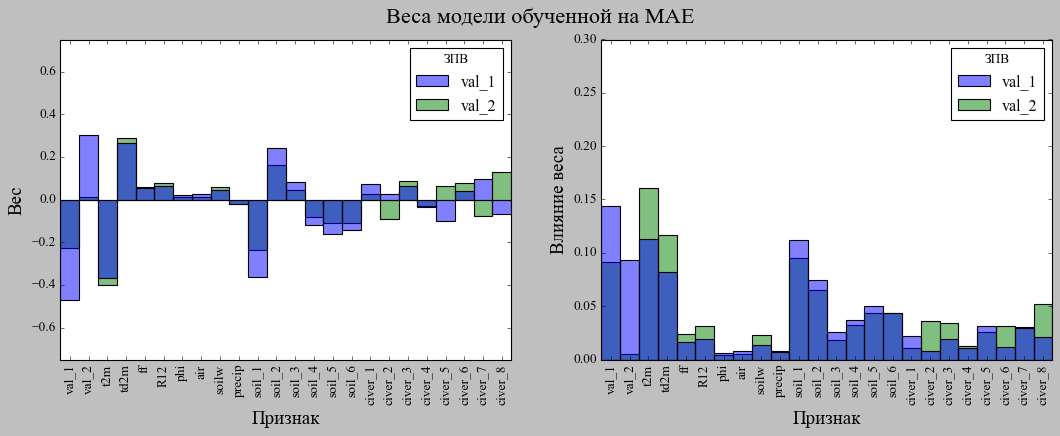

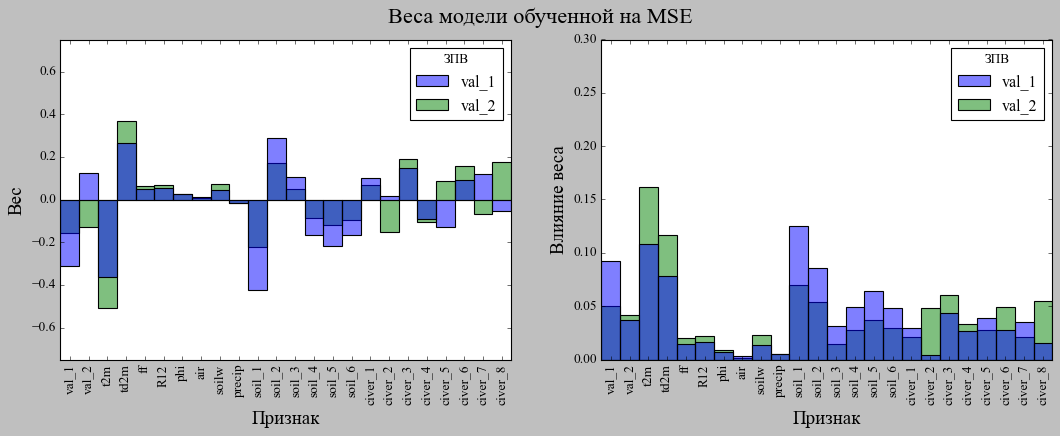

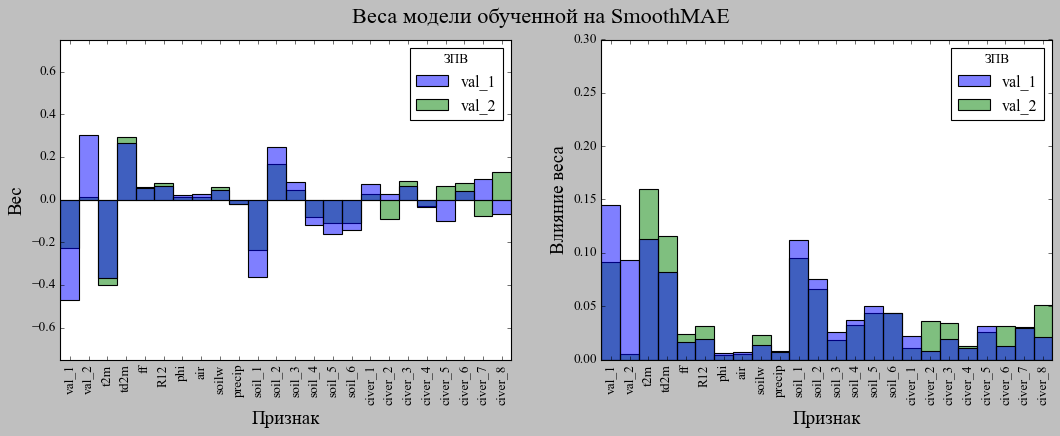

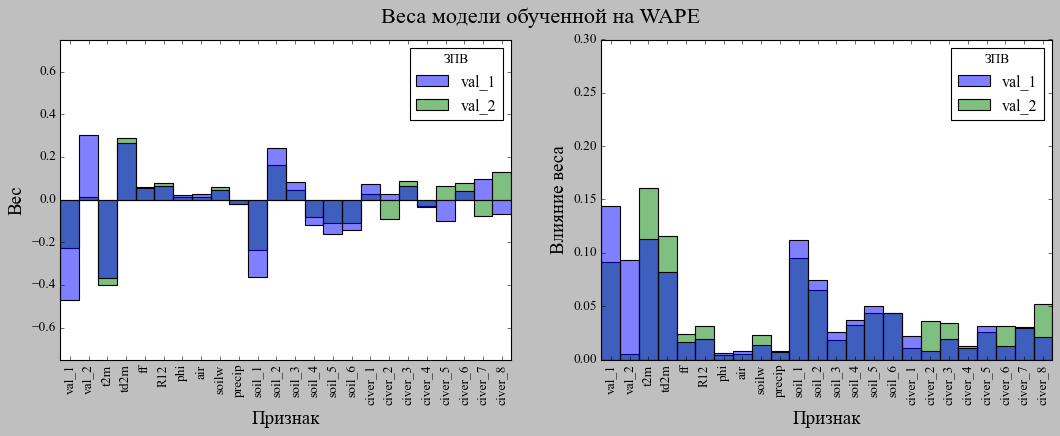

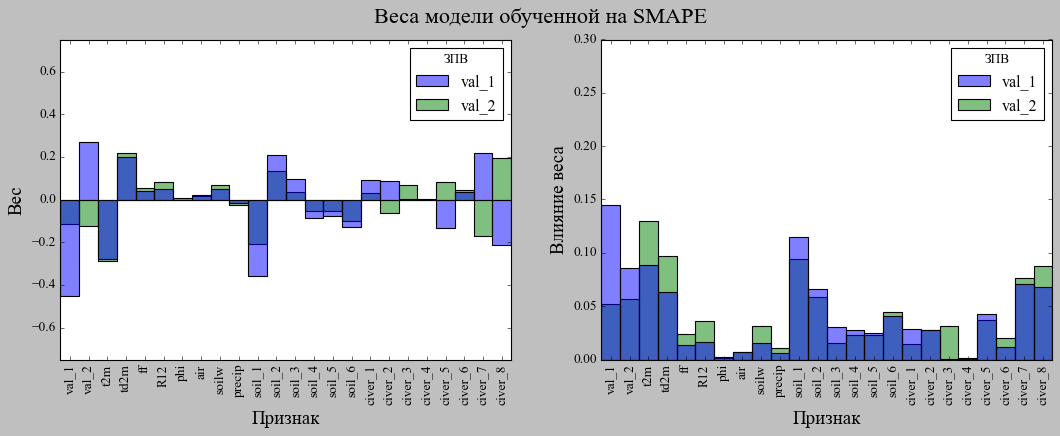

In [102]:
for i in range(6, 11):

    fig, ax = plt.subplots(ncols=2, figsize=(16, 5))

    func = EmbededLinearODEF(layers, embs, nn.Tanh)
    func.load_state_dict(torch.load(f'assets/exp{i}/model.pt', map_location=torch.device('cpu'))['model_state_dict'])
    func.eval()

    feature_name = ['val_1', 'val_2', 't2m', 'td2m', 'ff',
                    'R12', 'phi', 'air', 'soilw', 'precip']
    feature_name += [f'soil_{i+1}' for i in range(6)]
    feature_name += [f'civer_{i+1}' for i in range(8)]
    w1 = pd.DataFrame(func.reg.weight.data[0].numpy(), columns=['weight'])
    w2 = pd.DataFrame(func.reg.weight.data[1].numpy(), columns=['weight'])
    w1.loc[:, 'ЗПВ'] = 'val_1'
    w2.loc[:, 'ЗПВ'] = 'val_2'
    w1.loc[:, 'feature'] = feature_name
    w2.loc[:, 'feature'] = feature_name
    w1.loc[:, 'ratio'] = w1.weight.abs()/w1.weight.abs().sum()
    w2.loc[:, 'ratio'] = w2.weight.abs()/w2.weight.abs().sum()

    weights = pd.concat((w1, w2)).reset_index(drop=True)

    sns.histplot(x='feature', weights='weight', hue='ЗПВ', data=weights, discrete=True, stat='count', ax=ax[0])
    ax[0].set_xticklabels(weights.feature, rotation=90)
    ax[0].set_ylabel('Вес', size=17)
    ax[0].set_xlabel('Признак', size=17)
    ax[0].set_ylim(-0.75,0.75)

    sns.histplot(x='feature', weights='ratio', hue='ЗПВ', data=weights, discrete=True, stat='count', ax=ax[1])
    ax[1].set_xticklabels(weights.feature, rotation=90)
    ax[1].set_ylabel('Влияние веса', size=17)
    ax[1].set_xlabel('Признак', size=17)
    ax[1].set_ylim(0, .3)
    name = f'exp{i}'
    #plt.tight_layout(True)
    plt.suptitle(f'Веса модели обученной на {config[name]["lf"]}', size=20)
    plt.savefig(f'assets/{i}.png', papertype='a4', bbox_inches='tight', dpi=160)
    plt.show()
